# Summary
* This contains a from-scratch approach to preprocessing the original dataset.

The specific procedure is described in `Final Preprocessoing`. The rest are just investigations.

In [77]:
import json
fpath = 'data.json'
with open(fpath, 'rb') as fp:
    data = json.load(fp)
len(data)

21417

In [78]:
data[0].keys()

dict_keys(['x', 'y', 't'])

In [79]:
import numpy as np
def to_numpy(data_json):
    arr = np.zeros((len(data_json), 100, 3))
    for i in range(len(data_json)):
        x = data_json[i]['x']
        y = data_json[i]['y'] 
        t = data_json[i]['t']
        path_dt = list(zip(x, y, t))
        arr[i] = np.asarray(path_dt)
    return arr

In [80]:
out = to_numpy(data)
out.shape

(21417, 100, 3)

In [81]:
out.min(), out.max()

(-1.81718755, 5741.0)

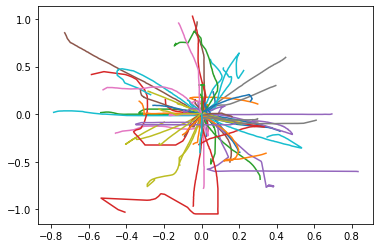

In [82]:
from pymousegan.plot import plot_paths
plot_paths(out[:80])

## Final Preprocessing
1. Convert from `json` to `np.array`.
2. Convert `t` to `dt` (lags)
3. Remove outliers.
    * Where `dt` > 1000
4. Minmax the `x, y` together to [-1, 1].
5. Minmax the `dt` to [0, 1].

In [1]:
import json
fpath = '../data/data.json'
with open(fpath, 'rb') as fp:
    data = json.load(fp)
len(data)

21417

In [2]:
import numpy as np
from pymousegan.io.preprocessor_v2 import preprocess

elapsed_thresh = 1250
preprocessed = preprocess(data, elapsed_thresh=elapsed_thresh)
preprocessed.shape, preprocessed.min(), preprocessed.max()

92 paths that have a lag > dt_thresh.
1267 paths that exceed elapsed_thresh.
1276 total number of outliers.
Before minmax normalization;dt min: 0.0dt max: 999.0


((20141, 100, 3), -1.0, 1.0)

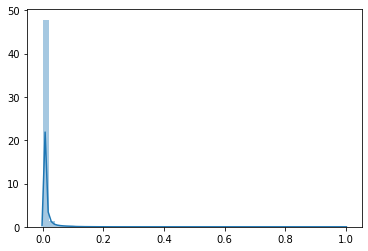

In [3]:
import seaborn as sns
%matplotlib inline
sns.distplot(preprocessed[:, :, -1].flatten())

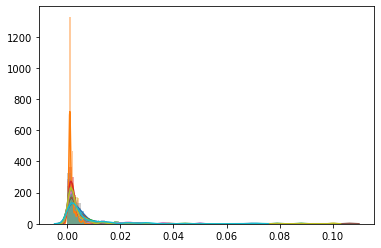

In [125]:
for dist in preprocessed[:10, :, -1]:
    sns.distplot(dist.flatten())

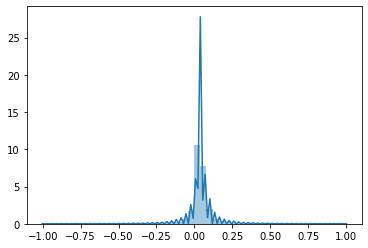

In [126]:
sns.distplot(preprocessed[:, :, 0].flatten())

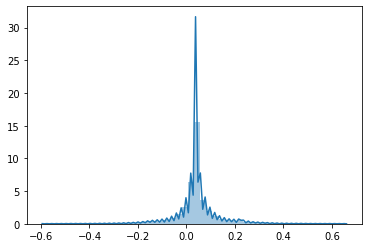

In [127]:
sns.distplot(preprocessed[:, :, 1].flatten())

In [128]:
np.save(f'preprocessed_{elapsed_thresh}_elapsed_thresh.npy', preprocessed)

## Looking at the timings
* Are they time differences?
* Or are they tracking the total time elapsed since the 1st movement?

In [46]:
i = 4
out[i, :, -1]

array([  0.,   6.,   9.,  11.,  15.,  16.,  18.,  20.,  24.,  25.,  26.,
        27.,  28.,  29.,  30.,  31.,  32.,  33.,  35.,  35.,  36.,  40.,
        41.,  44.,  47.,  51.,  53.,  57.,  59.,  62.,  63.,  64.,  65.,
        66.,  71.,  73.,  74.,  77.,  79.,  80.,  83.,  86.,  87.,  90.,
        96.,  97.,  98., 100., 101., 103., 104., 105., 106., 113., 116.,
       120., 126., 127., 129., 129., 131., 133., 133., 138., 142., 144.,
       146., 153., 154., 159., 165., 166., 169., 175., 178., 180., 181.,
       182., 183., 184., 202., 205., 209., 223., 231., 232., 245., 248.,
       252., 261., 264., 270., 281., 308., 311., 324., 374., 395., 400.,
       436.])

The answer: __total time elapsed.__ (because usually strictly increasing)

## t to dt
Changing the time elapsed to time differences (lags)

In [83]:
def t_to_dt_single(t):
    """Converts a single time-elapsed distribution to a distribution of lags.

    Args:
        t (1D np.ndarray/list/tuple): with n elements of elapsed times
    Returns:
        a numpy array of n lags
    """
    dt = np.zeros((len(t)))
    for i, elapsed in enumerate(t):
        if i == 0:
            dt[i] = 0
        else:
            dt[i] = t[i] - t[i-1]
    return dt

In [84]:
i = 4
out[i, :, -1]

array([  0.,   6.,   9.,  11.,  15.,  16.,  18.,  20.,  24.,  25.,  26.,
        27.,  28.,  29.,  30.,  31.,  32.,  33.,  35.,  35.,  36.,  40.,
        41.,  44.,  47.,  51.,  53.,  57.,  59.,  62.,  63.,  64.,  65.,
        66.,  71.,  73.,  74.,  77.,  79.,  80.,  83.,  86.,  87.,  90.,
        96.,  97.,  98., 100., 101., 103., 104., 105., 106., 113., 116.,
       120., 126., 127., 129., 129., 131., 133., 133., 138., 142., 144.,
       146., 153., 154., 159., 165., 166., 169., 175., 178., 180., 181.,
       182., 183., 184., 202., 205., 209., 223., 231., 232., 245., 248.,
       252., 261., 264., 270., 281., 308., 311., 324., 374., 395., 400.,
       436.])

In [85]:
t_to_dt_single(out[i, :, -1])

array([ 0.,  6.,  3.,  2.,  4.,  1.,  2.,  2.,  4.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  2.,  0.,  1.,  4.,  1.,  3.,  3.,  4.,
        2.,  4.,  2.,  3.,  1.,  1.,  1.,  1.,  5.,  2.,  1.,  3.,  2.,
        1.,  3.,  3.,  1.,  3.,  6.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,
        1.,  7.,  3.,  4.,  6.,  1.,  2.,  0.,  2.,  2.,  0.,  5.,  4.,
        2.,  2.,  7.,  1.,  5.,  6.,  1.,  3.,  6.,  3.,  2.,  1.,  1.,
        1.,  1., 18.,  3.,  4., 14.,  8.,  1., 13.,  3.,  4.,  9.,  3.,
        6., 11., 27.,  3., 13., 50., 21.,  5., 36.])

In [86]:
def t_to_dt(t_arr):
    """Converts the array of elapsed times to time differences (lags).
    """
    dt_arr = np.zeros(t_arr.shape)
    for i, t in enumerate(t_arr):
        dt_arr[i] = t_to_dt_single(t)
    return dt_arr

In [87]:
dt_arr = t_to_dt(out[:, :, -1])
dt_arr.min(), dt_arr.max(), dt_arr.shape

(0.0, 4701.0, (21417, 100))

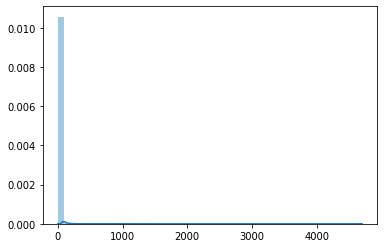

In [88]:
import seaborn as sns
%matplotlib inline
sns.distplot(dt_arr.flatten())

In [90]:
print(f'There are {len(np.unique(np.where(dt_arr > 100)[0]))} paths that have a dt > 100ms')
print(f'There are {len(np.unique(np.where(dt_arr > 250)[0]))} paths that have a dt > 250ms')
print(f'There are {len(np.unique(np.where(dt_arr > 500)[0]))} paths that have a dt > 500ms')
print(f'There are {len(np.unique(np.where(dt_arr > 1000)[0]))} paths that have a dt > 1s')

There are 7563 paths that have a dt > 100ms
There are 1619 paths that have a dt > 250ms
There are 413 paths that have a dt > 500ms
There are 92 paths that have a dt > 1s


In [95]:
np.unique(np.where(dt_arr > 1000))

array([    1,    93,    97,    99,  1821,  4314,  4969,  6972,  7566,
        8720,  9083,  9559,  9650,  9667,  9700,  9716,  9719,  9726,
        9731,  9768,  9777,  9792,  9794,  9799,  9809,  9835,  9875,
        9879,  9885,  9888,  9889,  9926,  9941,  9971, 10007, 10008,
       10017, 10048, 10072, 10080, 10090, 10092, 10112, 10140, 10212,
       10220, 10260, 10299, 10312, 10319, 10327, 10341, 10388, 10410,
       10412, 10450, 10472, 10511, 10518, 10539, 10560, 10564, 10568,
       10574, 10579, 10590, 10621, 10627, 10635, 10640, 10693, 10700,
       15822, 15837, 15841, 15846, 15885, 15891, 15893, 15896, 15900,
       15904, 15914, 15915, 15917, 15933, 15954, 15956, 15957, 15962,
       15966, 15967, 15991, 15992, 15993, 16058], dtype=int64)

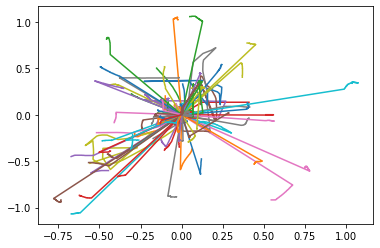

In [92]:
plot_paths(out[np.unique(np.where(dt_arr > 1000))])

All of the paths that have >= 1 lag of at least 1s are generally pretty straight.

## Normalize (x, y) and t separately

In [59]:
def minmax_normalize(arr, norm_range=[-1, 1], minmax=None):
    """
    Args:
        arr: numpy array
        minmax (Iterable[float]): (min, max) where
            min (float): minimum of the dataset
            max (float): maximum of the dataset
        norm_range: list of 2 integers specifying normalizing range
            based on https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
    Returns:
        Normalized array with outliers clipped in the specified range
    """
    if minmax is not None:
        min, max = minmax
    else:
        min, max = np.amin(arr), np.amax(arr)
    norm_img = ((norm_range[1]-norm_range[0]) * (arr - min) / (max - min)) + norm_range[0]
    return norm_img

In [29]:
out[:, :, :-1] = minmax_normalize(out[:, :, :-1])
out[:, :, -1] = minmax_normalize(out[:, :, -1])
out.min(), out.max()

(-1.0, 1.0)

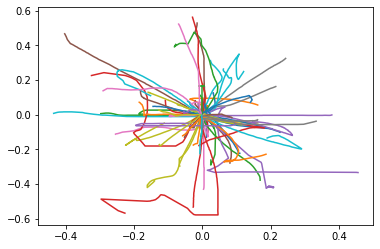

In [31]:
from pymousegan.plot import plot_paths
plot_paths(out[:80])

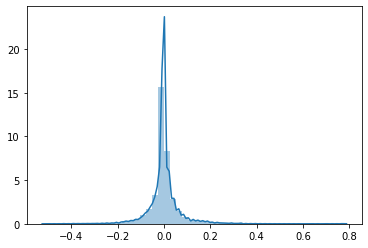

In [32]:
import seaborn as sns
%matplotlib inline
# X
sns.distplot(out[:1000, :, 0].flatten())

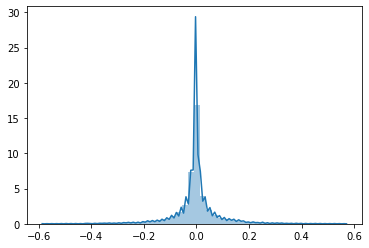

In [33]:
# Y
sns.distplot(out[:1000, :, 1].flatten())

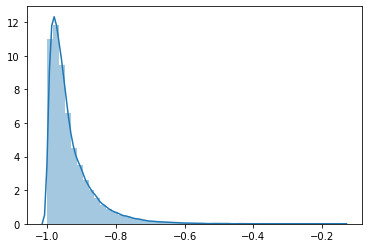

In [34]:
# t
sns.distplot(out[:1000, :, -1].flatten())

## Only Min Max Norm
No bueno because it still takes into account the huge outliers. So, that means we need to either take out the outliers or scale them down.

In [37]:
def minmax_normalize(arr, norm_range=[-1, 1], minmax=None):
    """
    Args:
        arr: numpy array
        minmax (Iterable[float]): (min, max) where
            min (float): minimum of the dataset
            max (float): maximum of the dataset
        norm_range: list of 2 integers specifying normalizing range
            based on https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
    Returns:
        Normalized array with outliers clipped in the specified range
    """
    if minmax is not None:
        min, max = minmax
    else:
        min, max = np.amin(arr), np.amax(arr)
    norm_img = ((norm_range[1]-norm_range[0]) * (arr - min) / (max - min)) + norm_range[0]
    return norm_img

In [38]:
norm_arr = minmax_normalize(out)
norm_arr.min(), norm_arr.max()

(-1.0, 1.0)

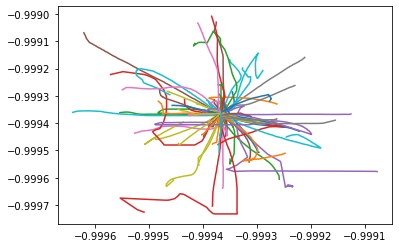

In [40]:
from pymousegan.plot import plot_paths
plot_paths(norm_arr[:80])

## Handling Outliers

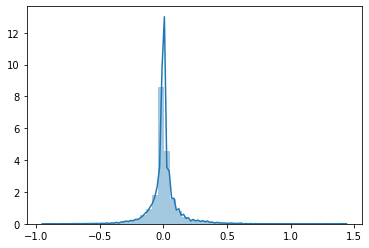

In [11]:
import seaborn as sns
%matplotlib inline
# X
sns.distplot(out[:1000, :, 0].flatten())

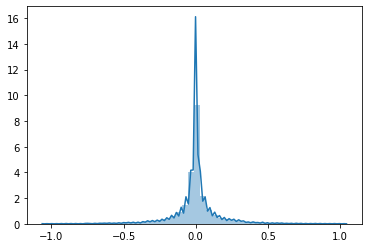

In [21]:
# Y
sns.distplot(out[:1000, :, 1].flatten())

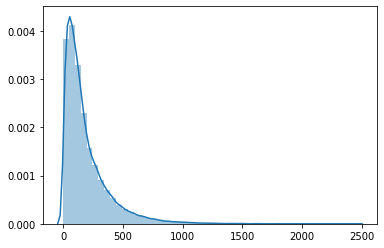

In [22]:
# t
sns.distplot(out[:1000, :, -1].flatten())

In [17]:
paths_only = out[:, :, :-1]
print(f'The outlier paths are at indices: {np.unique(np.where(paths_only > 1.5)[0])}.')

The outlier paths are at indices: [ 7177  8842 13668 20257].


In [23]:
for idx in [7177, 8842, 13668, 20257]:
    outlier_arr = paths_only[idx]
    print(f'Min: {outlier_arr.min()}, Max: {outlier_arr.max()}')

Min: 0.0, Max: 1.8265624
Min: 0.0, Max: 1.69635415
Min: -0.8375487, Max: 1.521875
Min: -0.715306163, Max: 1.6833334


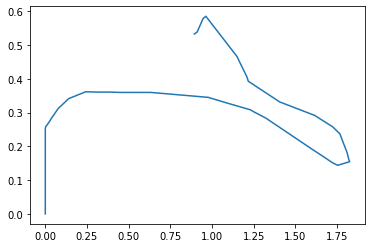

In [24]:
plot_paths(out[7177:7177+1])